In [1]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt
import math
import torch
import spinup
import multiprocessing as mp

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from spinup.algos.pytorch.ddpg.core import MLPActorCritic

%matplotlib notebook

In [2]:
from src import *
from src.constants import DT, MAX_X, MAX_Y, BALL_ERROR_SCALING, BALL_D_ERROR_SCALING, BALL_INTEGRAL_ERROR_SCALING

In [3]:
train = False

In [4]:
with open('src/data/benchmark_trajectory.json') as json_file:
    benchmark_data = json.load(json_file)

In [5]:
t = np.array(benchmark_data['t'])
test_trajectory = np.array(benchmark_data['target'])
benchmark_trajectory = np.array(benchmark_data['trajectory'])
benchmark_angle = np.array(benchmark_data['angle'])
benchmark_u = np.array(benchmark_data['u'])

# Exploration

In [6]:
epoch = 250

In [7]:
root = 'src/data/black_box_controller/explo'

In [8]:
env = BBEnv
ac = MLPActorCritic
reward_fn = linear_e_reward
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='le0.3_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.00789997,  0.04045815], dtype=float32), array([-0.06233123, -0.06440674], dtype=float32), array([-0.0027971 ,  0.00057722], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


-0.0003499770185420214


<IPython.core.display.Javascript object>


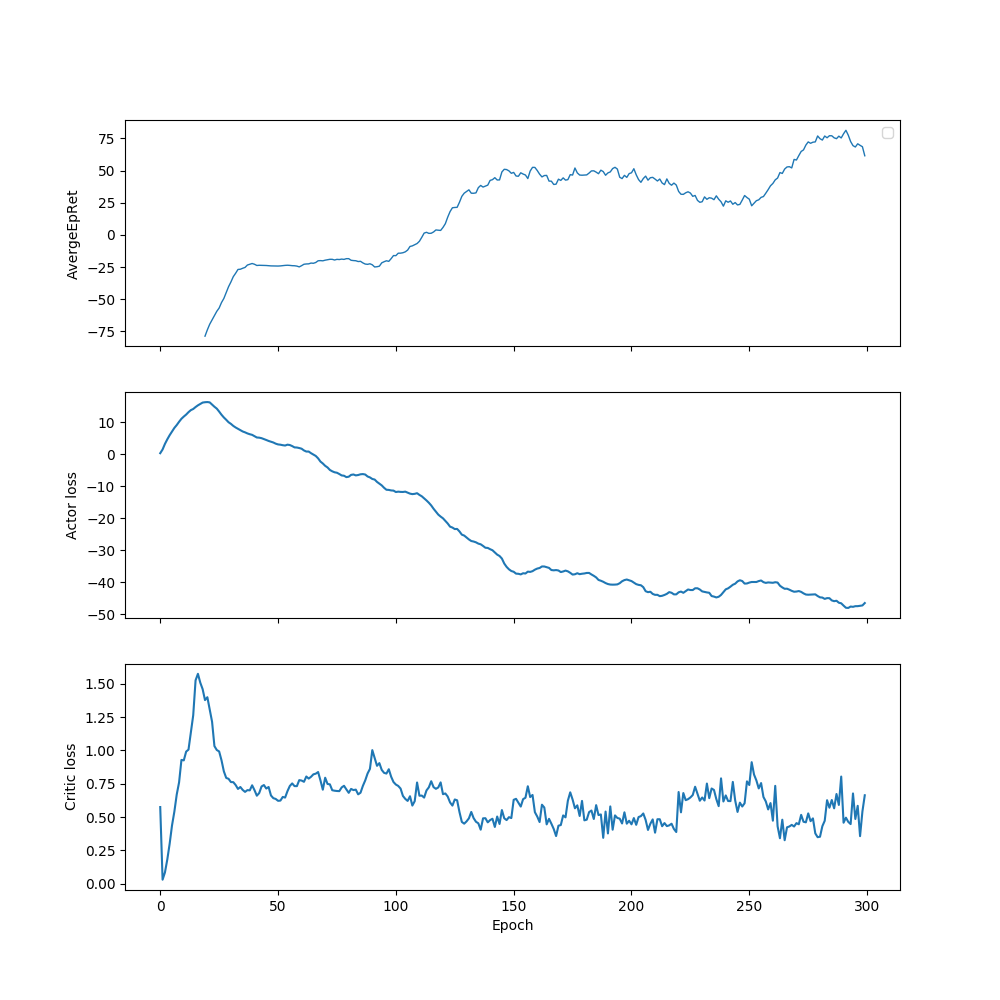

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


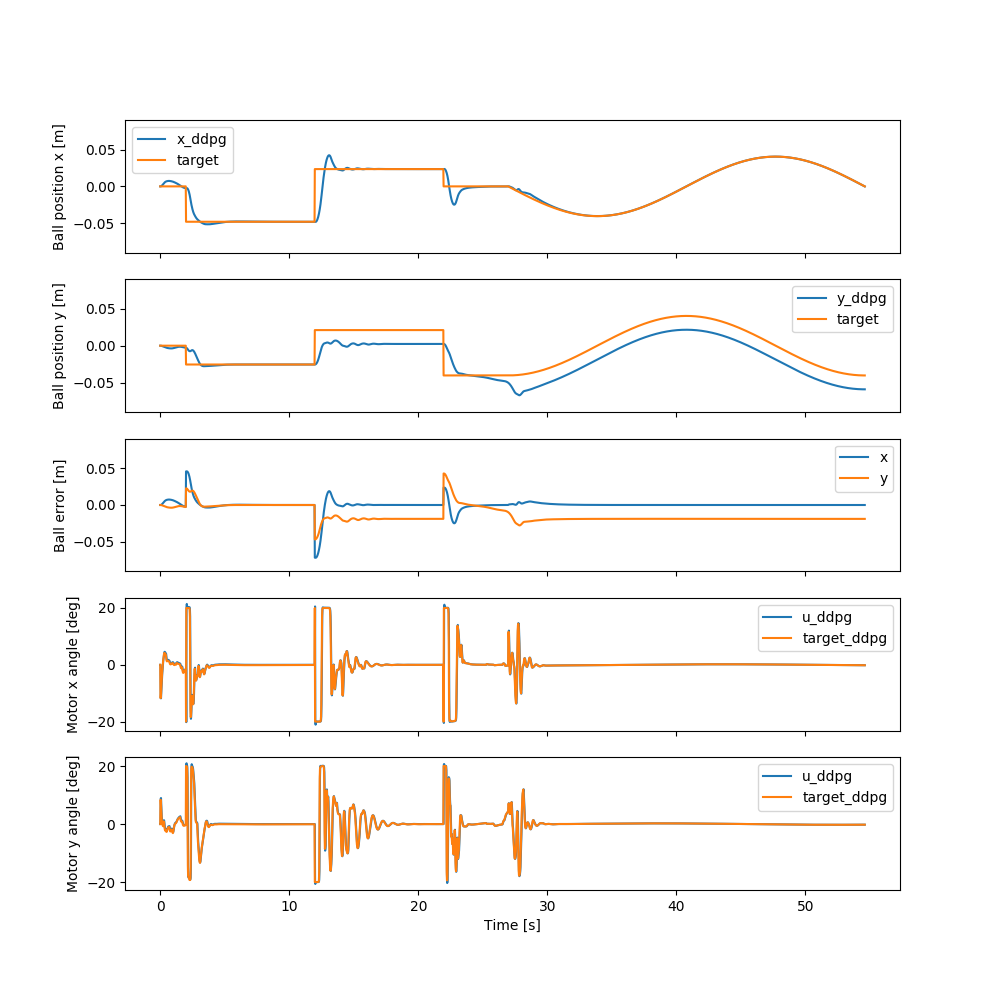

In [9]:
if False:#train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 15000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [10]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward
w = 1
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='pe1_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([ 0.0199491 , -0.02242357], dtype=float32), array([0.01446999, 0.01845334], dtype=float32), array([0.00299341, 0.00115433], dtype=float32))
-0.00016916548421626006


<IPython.core.display.Javascript object>


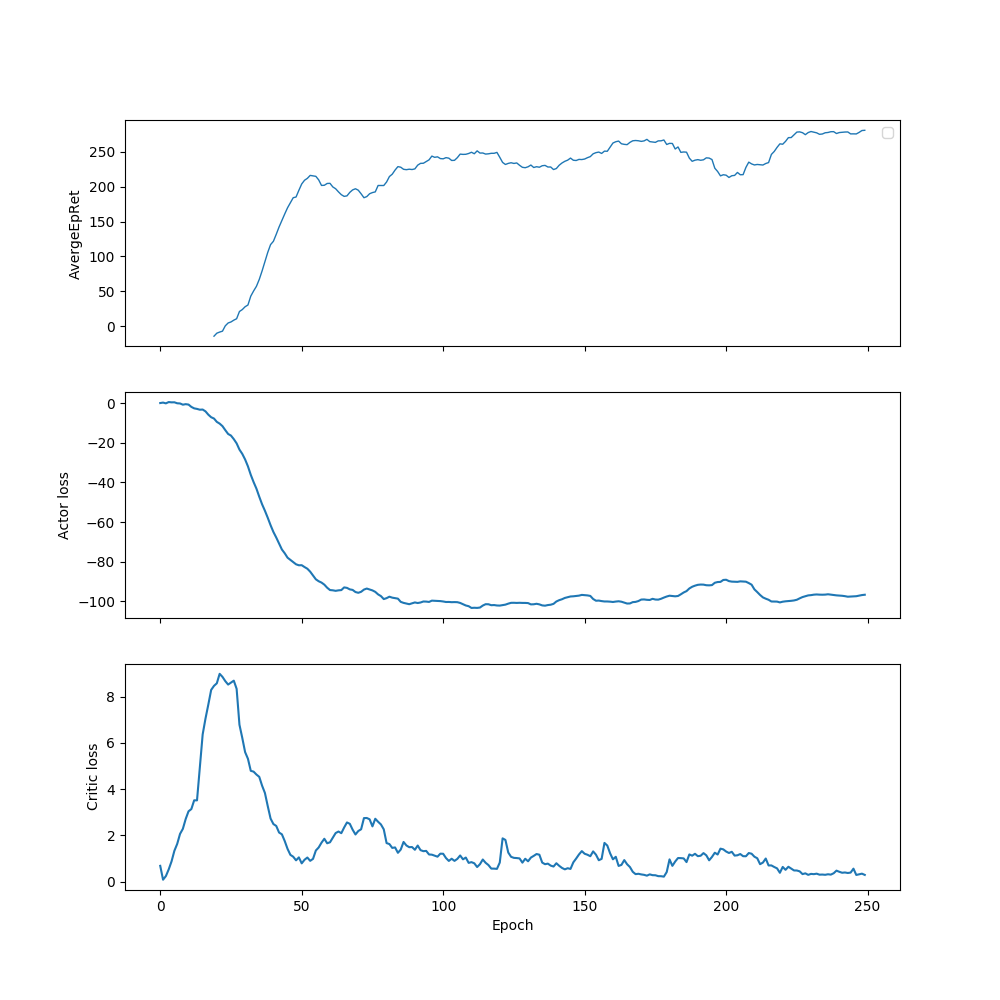

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


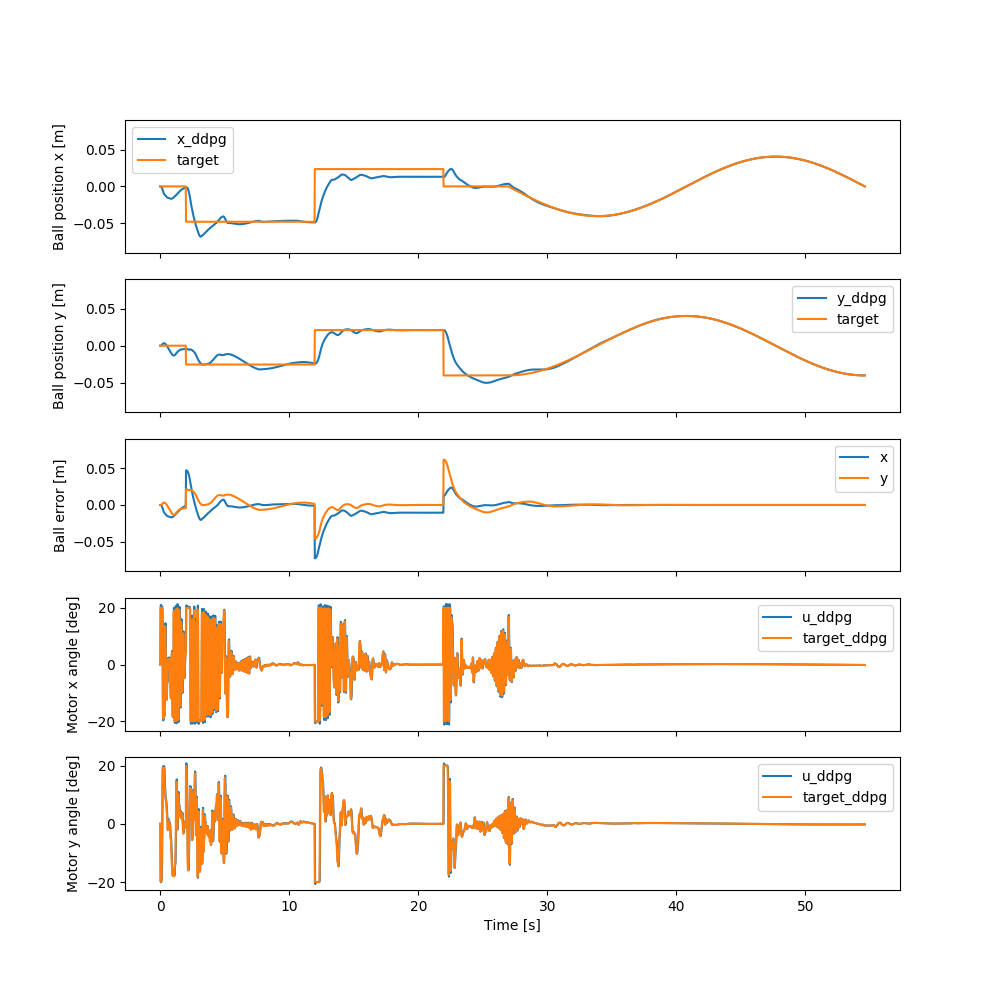

In [11]:
if False:#train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 15000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [12]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='pep0.3_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([ 0.00229321, -0.01225767], dtype=float32), array([-0.01655909,  0.00731016], dtype=float32), array([0.00290987, 0.00066779], dtype=float32))
-19810.662762983746


<IPython.core.display.Javascript object>


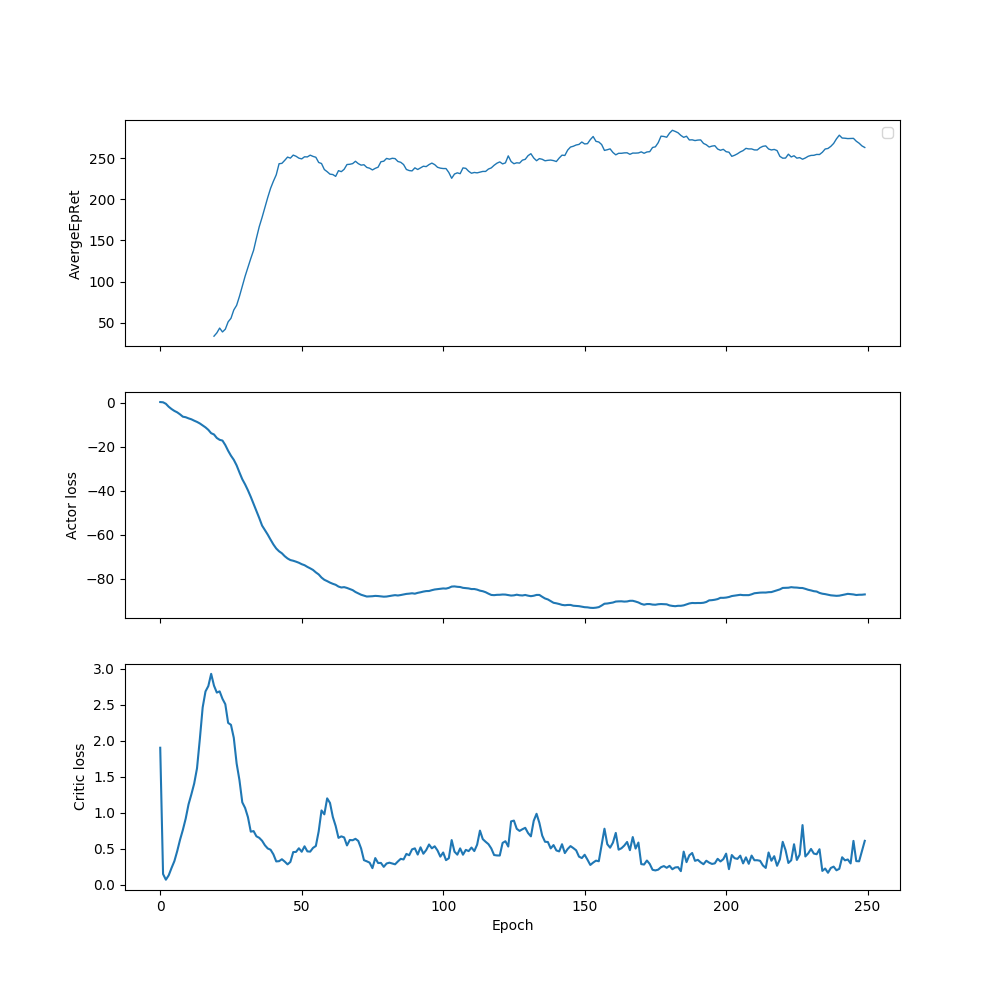

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


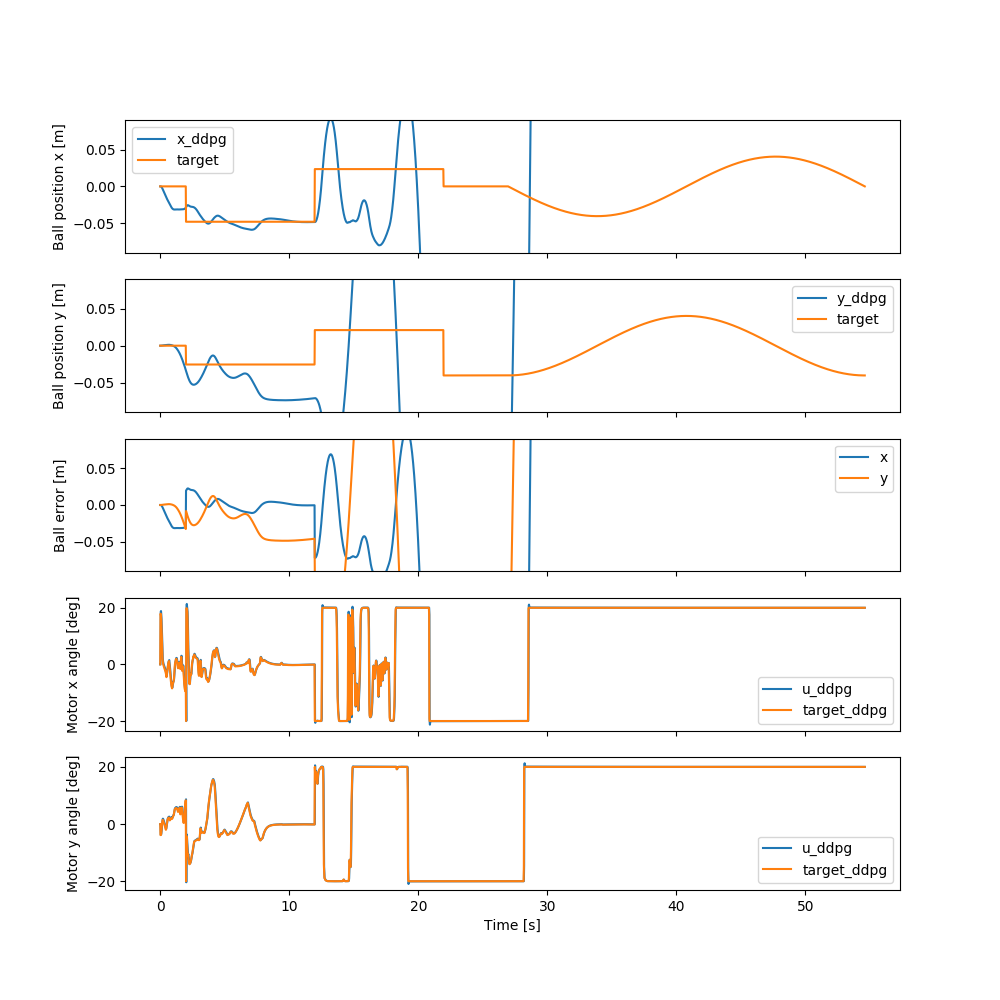

In [13]:
if False:#train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 15000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [14]:
env = BBEnv
ac = MLPActorCritic
reward_fn = linear_de_reward
w = 15
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='de15_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([ 0.04812992, -0.05184015], dtype=float32), array([-0.05471395,  0.05340971], dtype=float32), array([-0.00169951, -0.00244469], dtype=float32))
-0.0014316889869751001


<IPython.core.display.Javascript object>


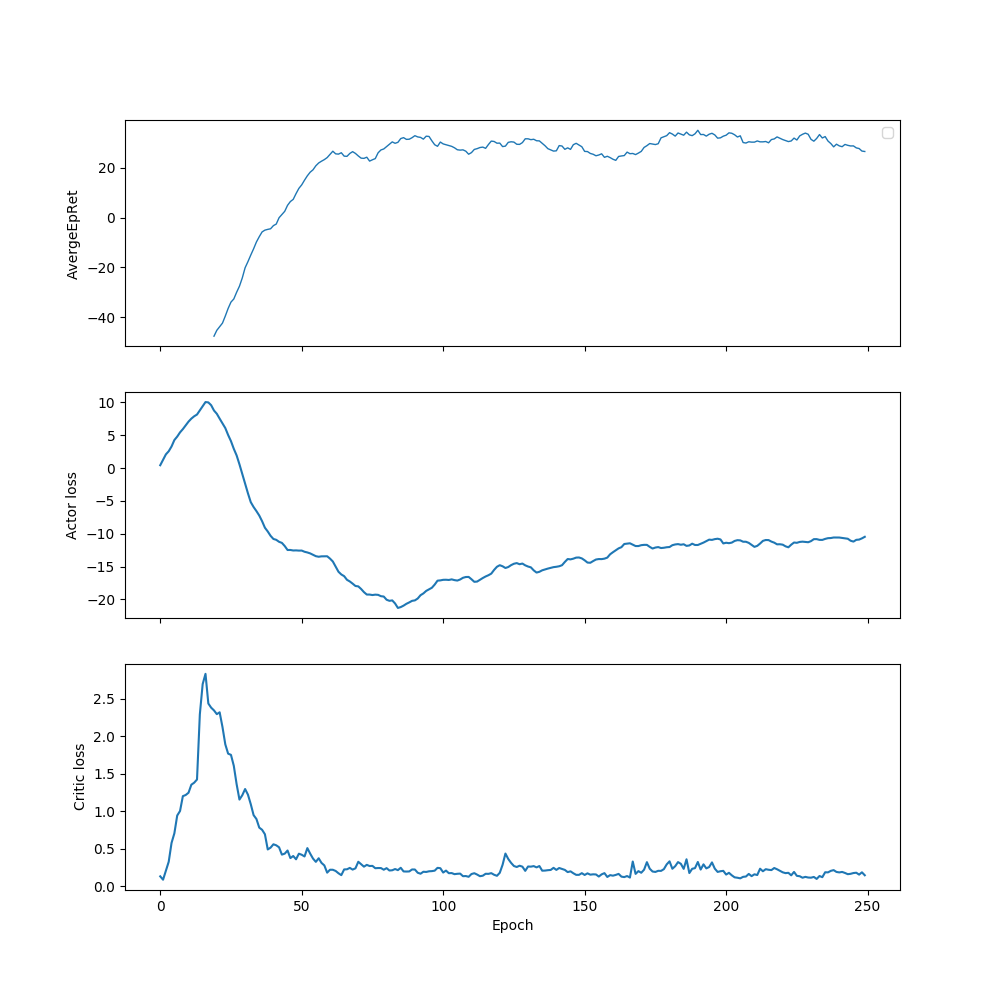

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


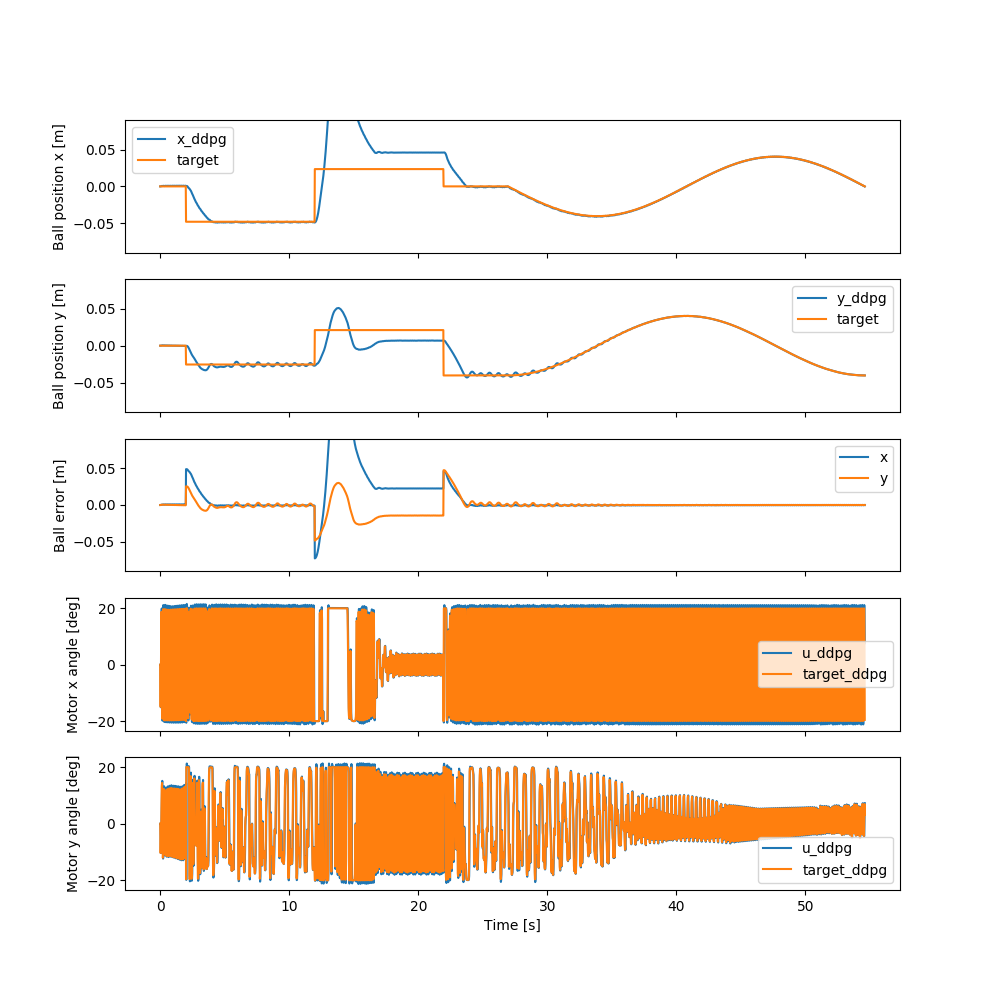

In [15]:
if False:#train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 15000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [16]:
env = BBEnv
ac = MLPActorCritic
reward_fn = linear_e_reward
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.Sigmoid
name='le0.3_[100]_signmoid_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.02509248,  0.00184072], dtype=float32), array([0.00951293, 0.05345134], dtype=float32), array([-0.00140964,  0.00101811], dtype=float32))
-4.007780417553988


<IPython.core.display.Javascript object>


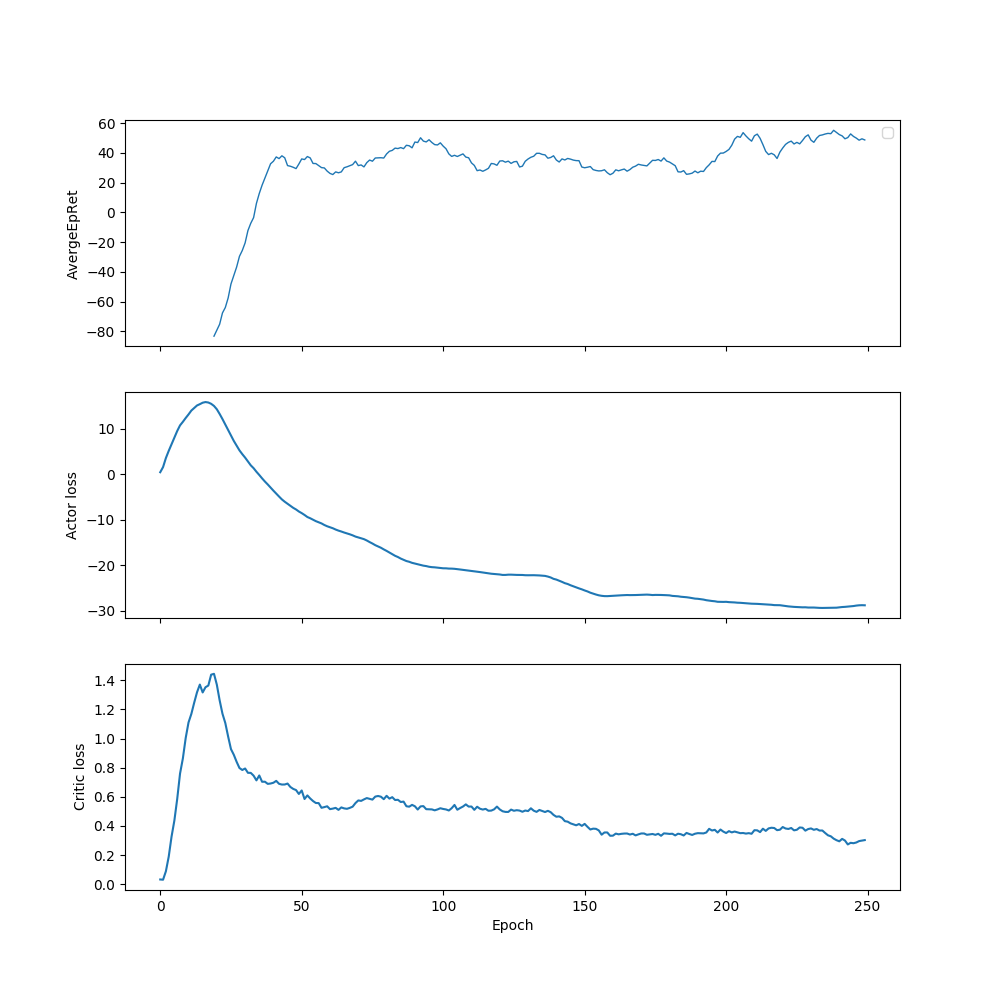

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


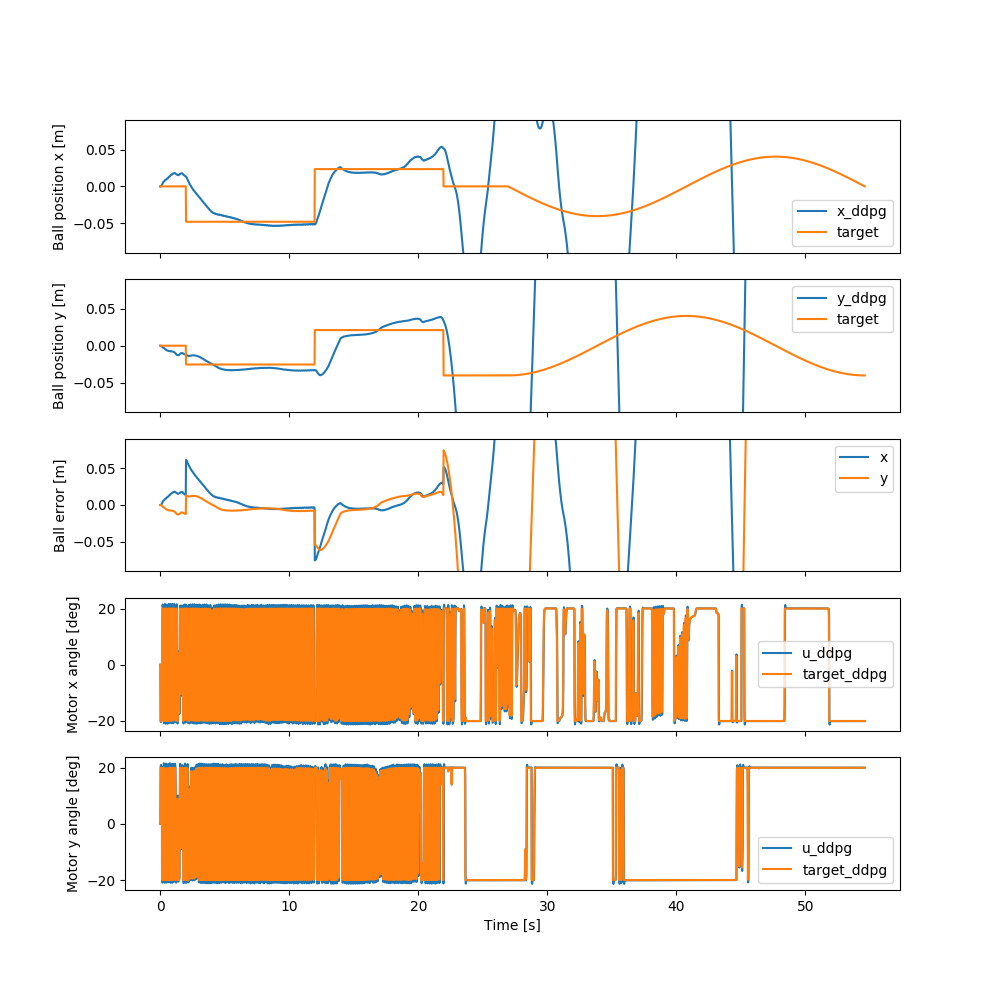

In [17]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 150000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [18]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward
w = 1
hidden_size = [100]
gamma = 0.99
act = torch.nn.Sigmoid
name='pe1_[100]_sigmoid_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.06680886,  0.06586093], dtype=float32), array([-0.04120148,  0.05612379], dtype=float32), array([0.00292992, 0.00256972], dtype=float32))
-0.0008167436327208523


<IPython.core.display.Javascript object>


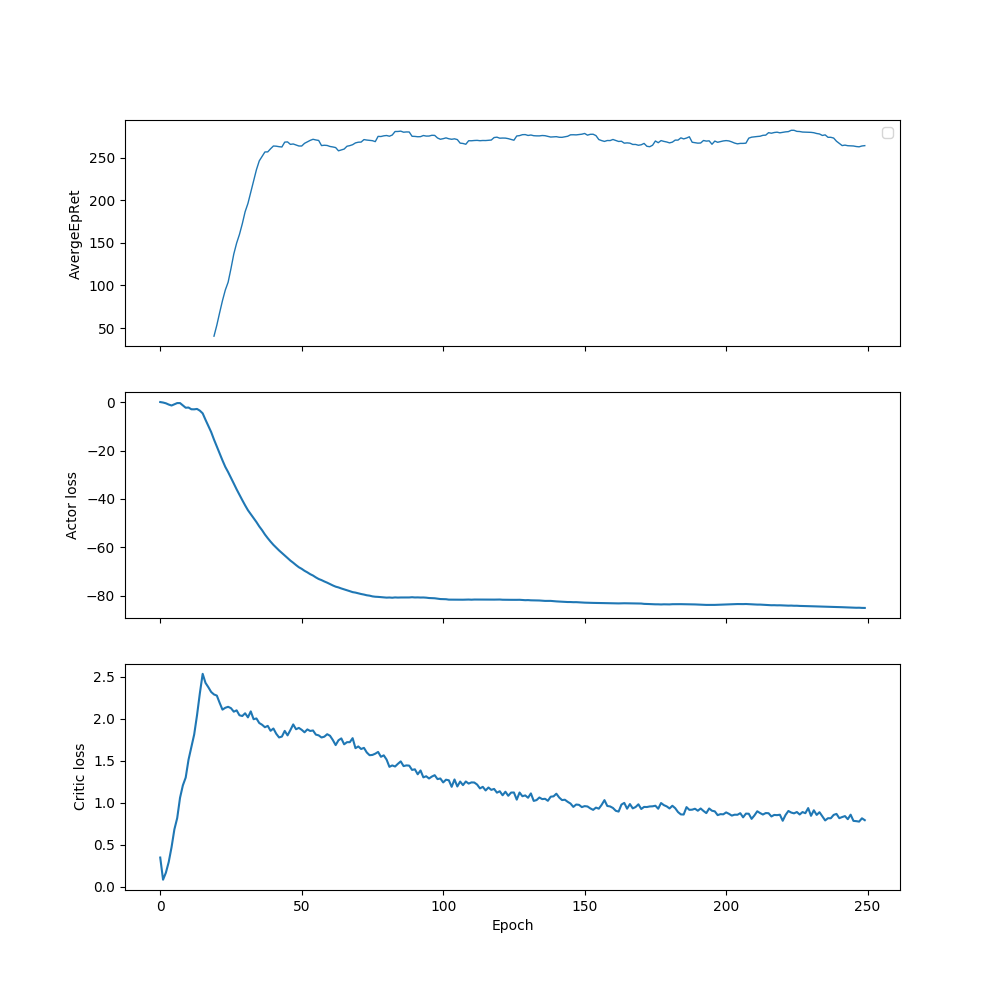

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


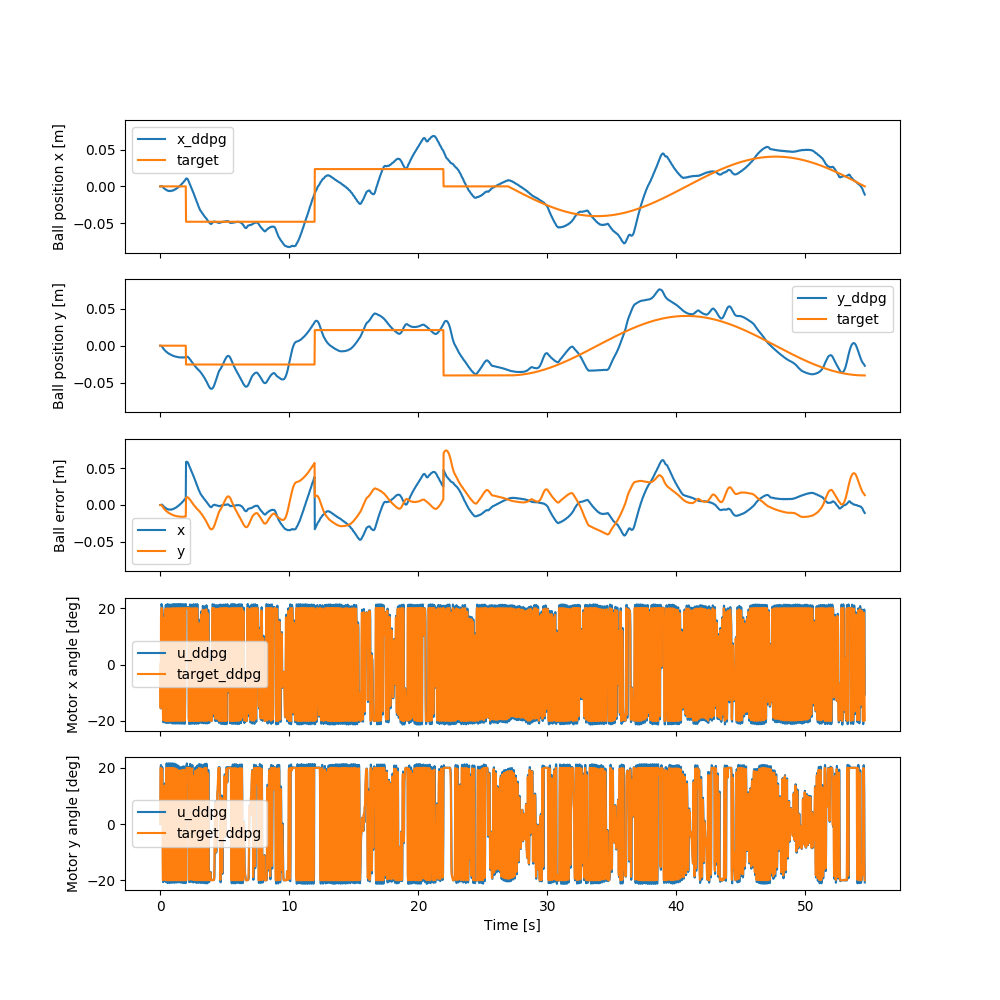

In [19]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [20]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.Sigmoid
name='pep0.3_[100]_sigmoid_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([ 0.00791005, -0.00087513], dtype=float32), array([-0.06096811, -0.03538873], dtype=float32), array([0.00138614, 0.00088814], dtype=float32))
-0.0007985239095186683


<IPython.core.display.Javascript object>


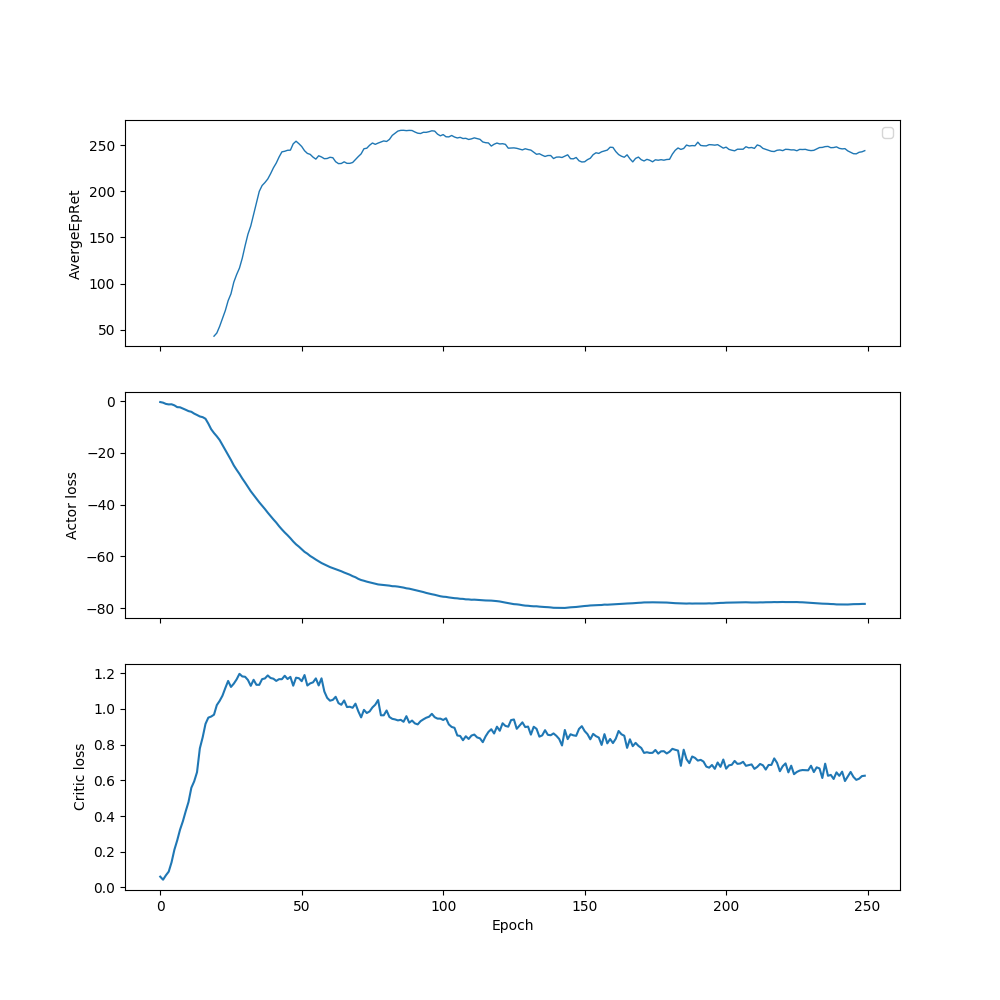

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


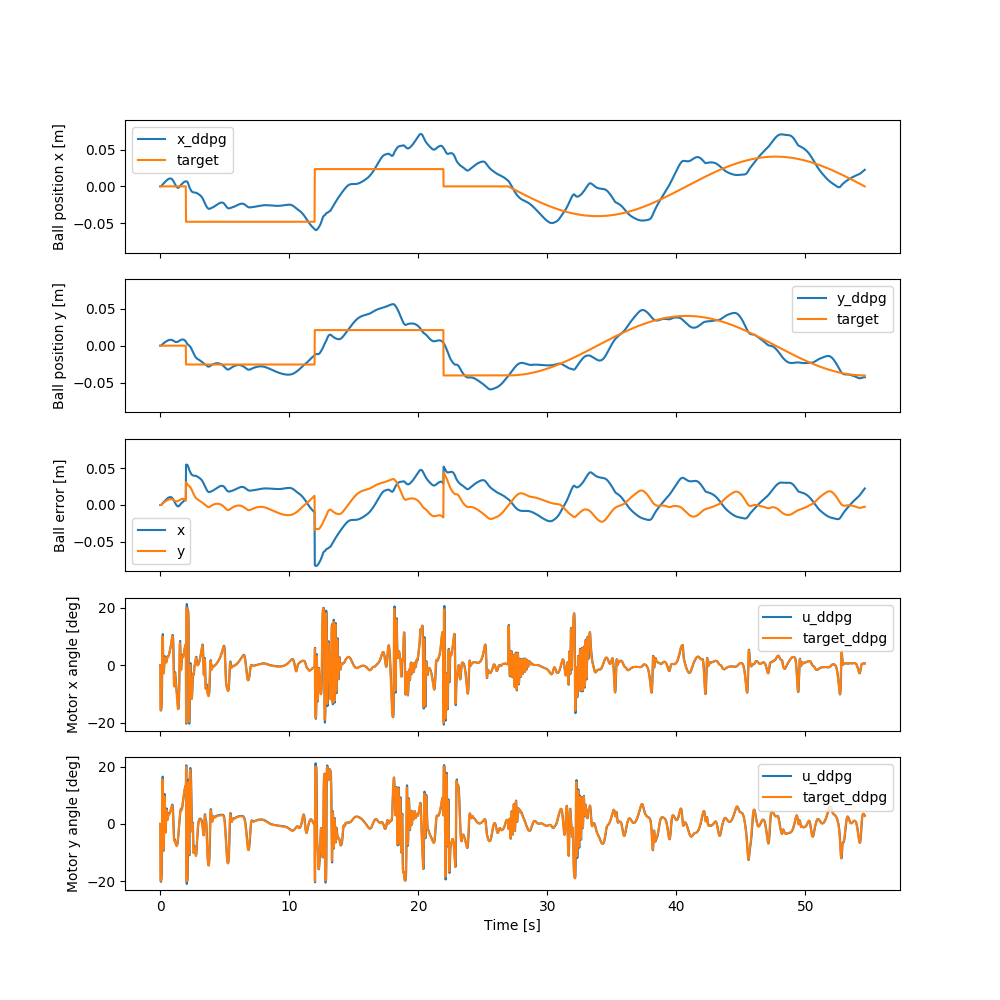

In [21]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [22]:
env = BBEnv
ac = MLPActorCritic
reward_fn = linear_de_reward
w = 15
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='de15_[100]_sigmoid_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.07106724, 0.03167953], dtype=float32), array([-0.02692133,  0.00373475], dtype=float32), array([ 0.00252676, -0.00211058], dtype=float32))
-0.0001462247214260638


<IPython.core.display.Javascript object>


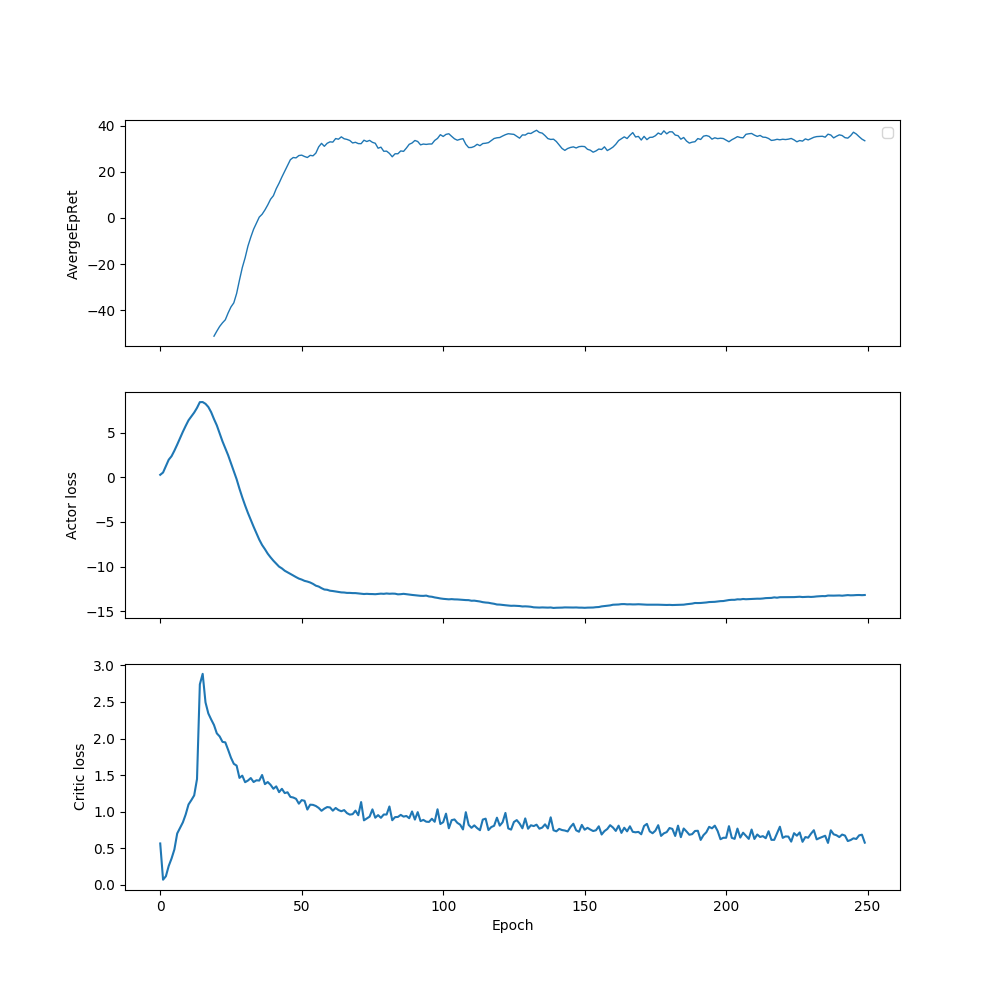

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


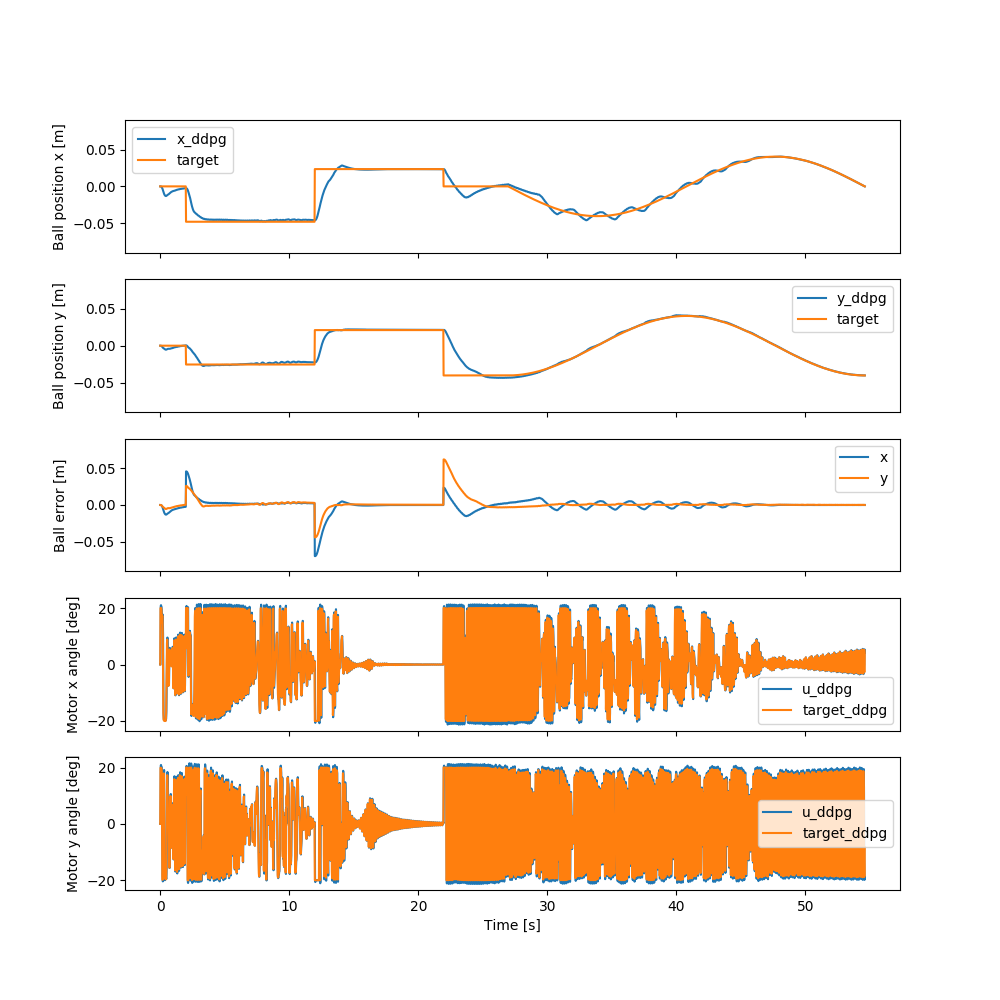

In [23]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [24]:
env = BBEnv
ac = MLPActorCritic
reward_fn = linear_e_reward
w = 0.6
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='le0.6_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.03039021,  0.04379907], dtype=float32), array([-0.06473632, -0.03829878], dtype=float32), array([-0.00272043,  0.00109485], dtype=float32))
-0.0001550869582021654


<IPython.core.display.Javascript object>


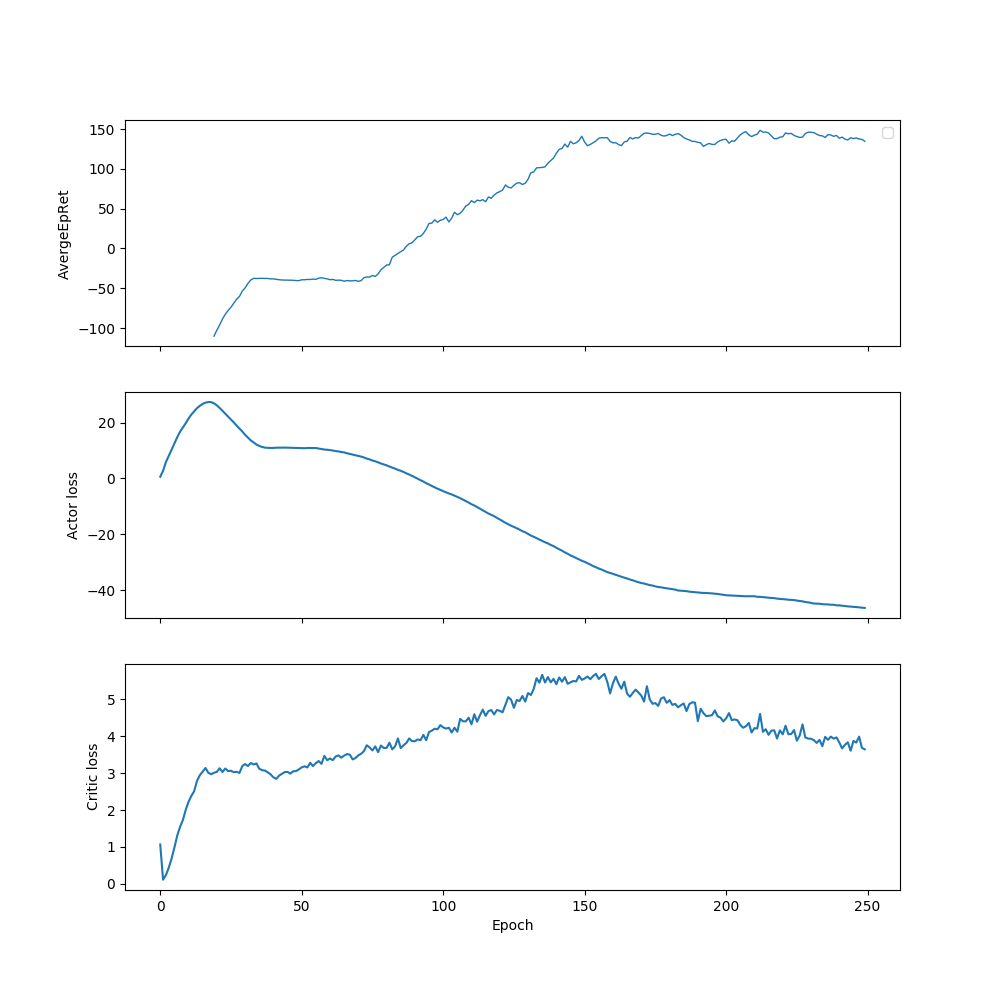

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


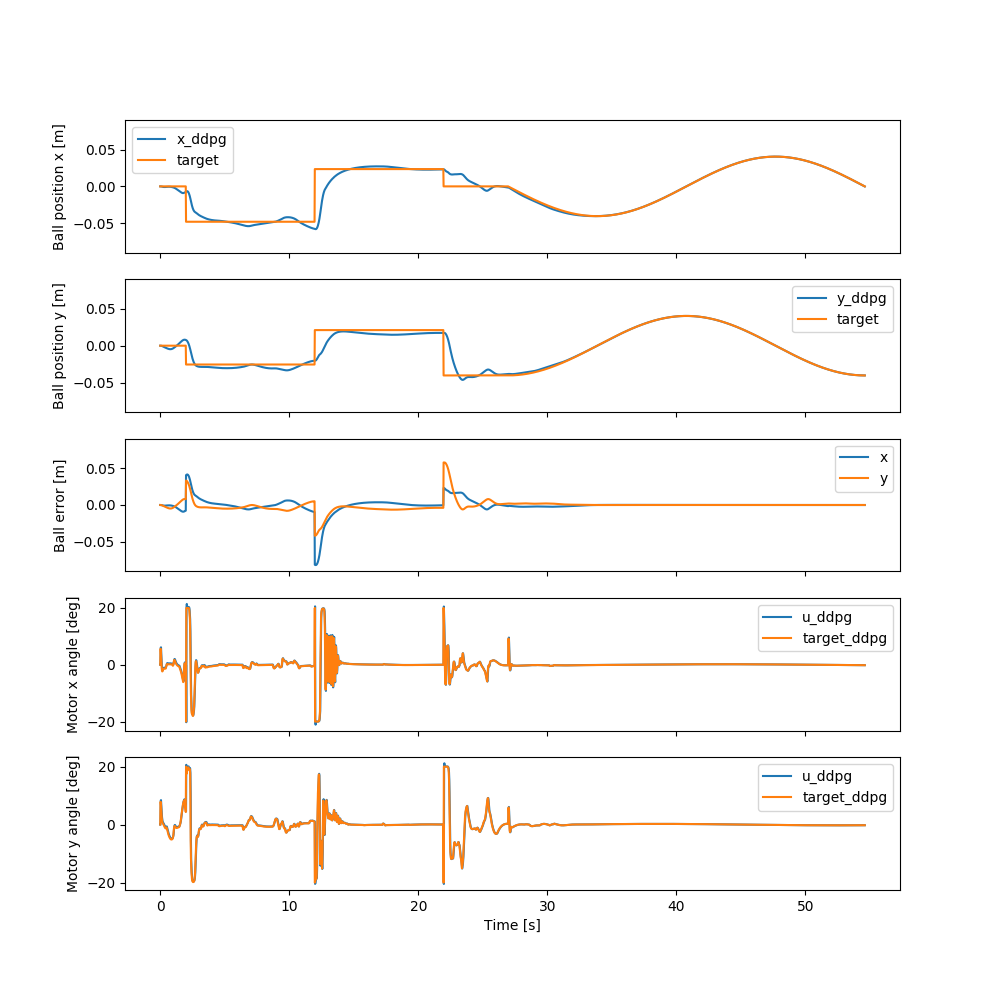

In [25]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [26]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward
w = 1.4
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='pe1.4_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([ 0.06034743, -0.05165723], dtype=float32), array([ 0.06270899, -0.01787134], dtype=float32), array([-0.00277638,  0.00141347], dtype=float32))
-0.0002303432219834078


<IPython.core.display.Javascript object>


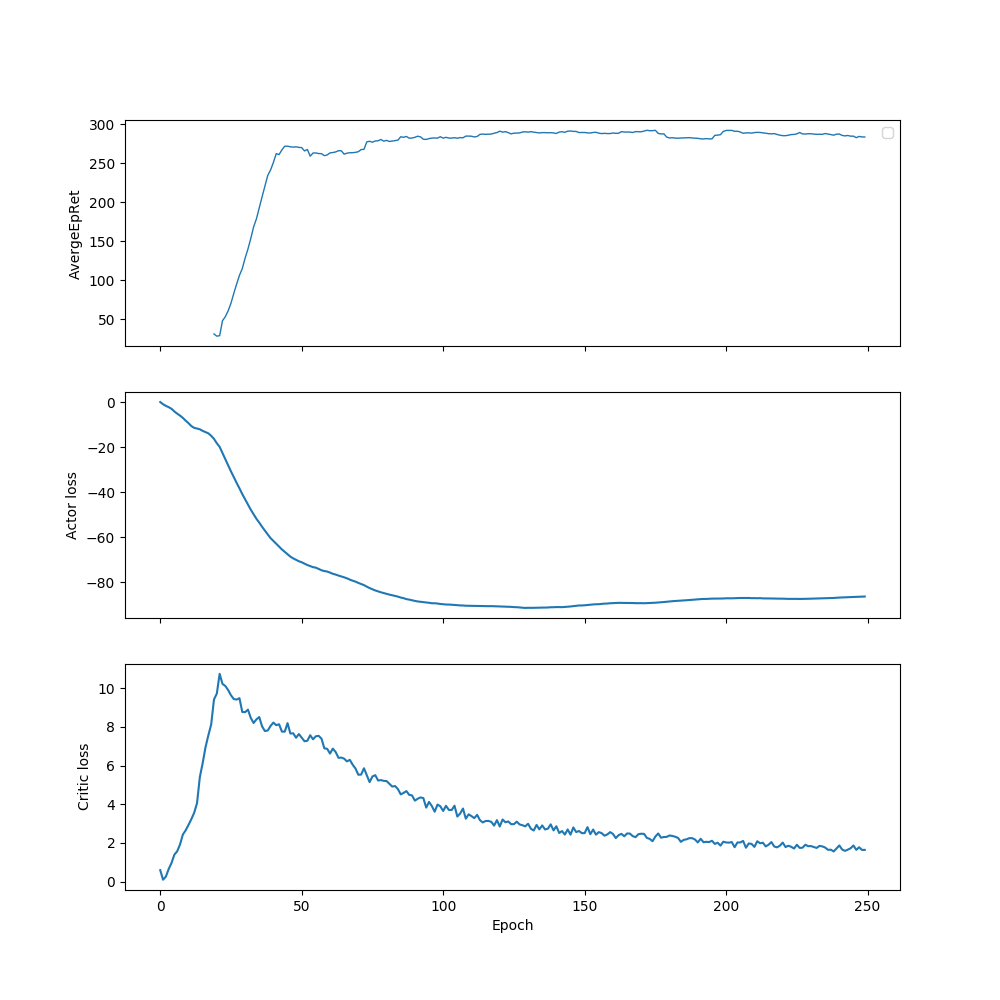

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


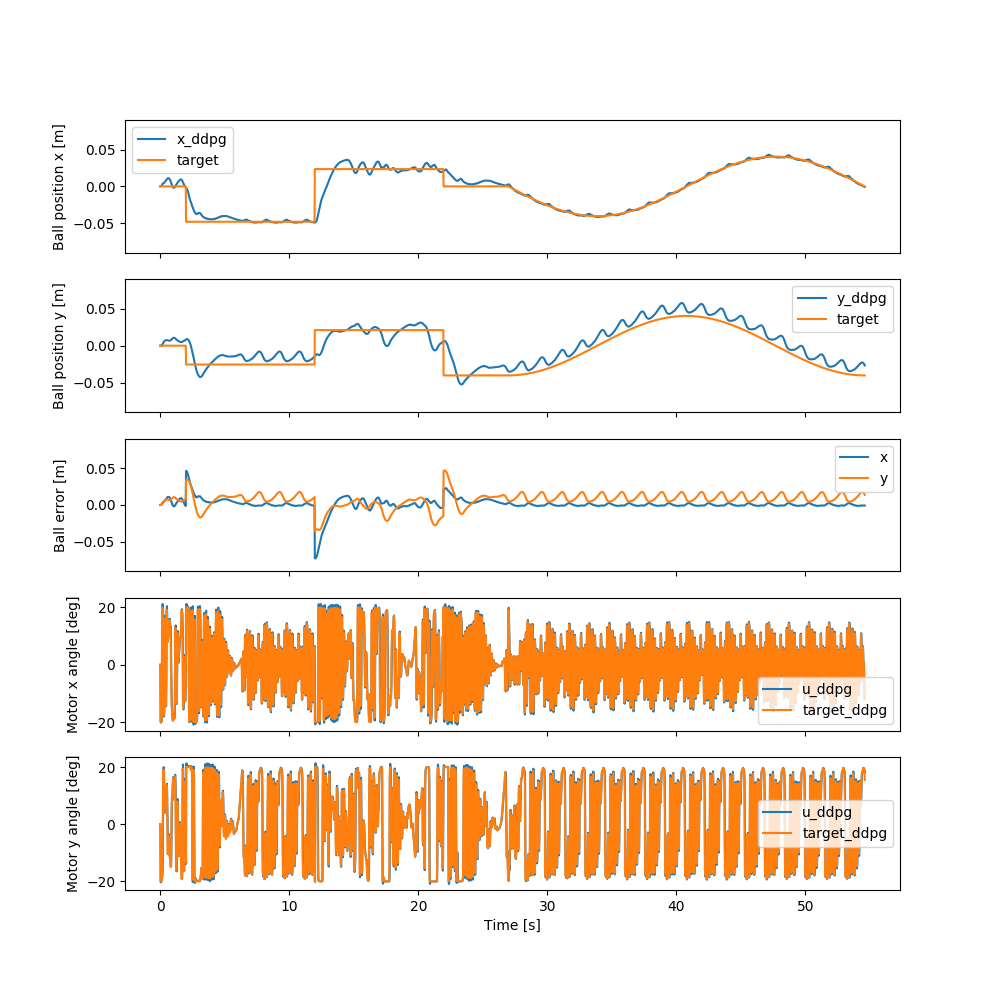

In [27]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [28]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.6
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='pep0.6_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.0274439 , -0.04278435], dtype=float32), array([-0.02943091, -0.03580199], dtype=float32), array([ 0.00189008, -0.00208641], dtype=float32))
-0.0030130292850828098


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


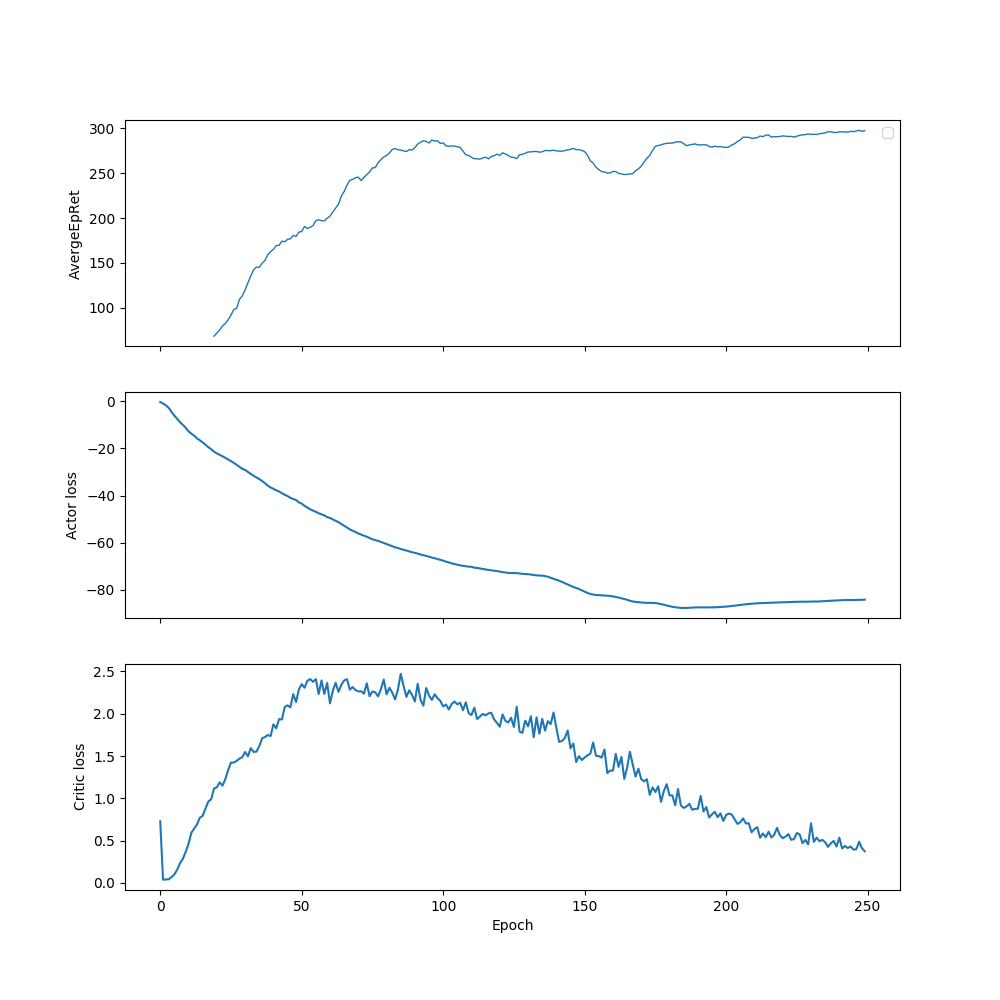

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


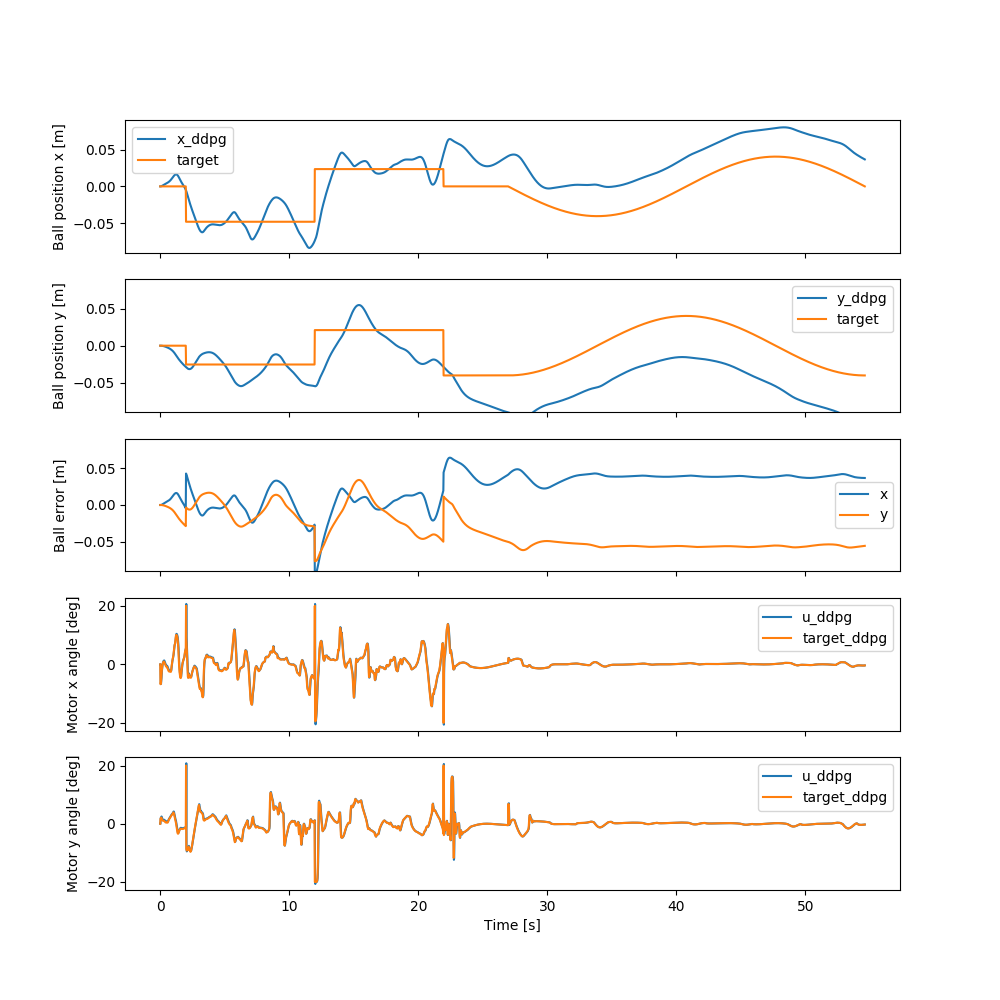

In [29]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [30]:
env = BBEnv
ac = MLPActorCritic
reward_fn = linear_de_reward
w = 5
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='de5_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.01113507, 0.04798177], dtype=float32), array([-0.0213584,  0.035446 ], dtype=float32), array([0.00097545, 0.00241974], dtype=float32))
-0.0013157208634683585


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


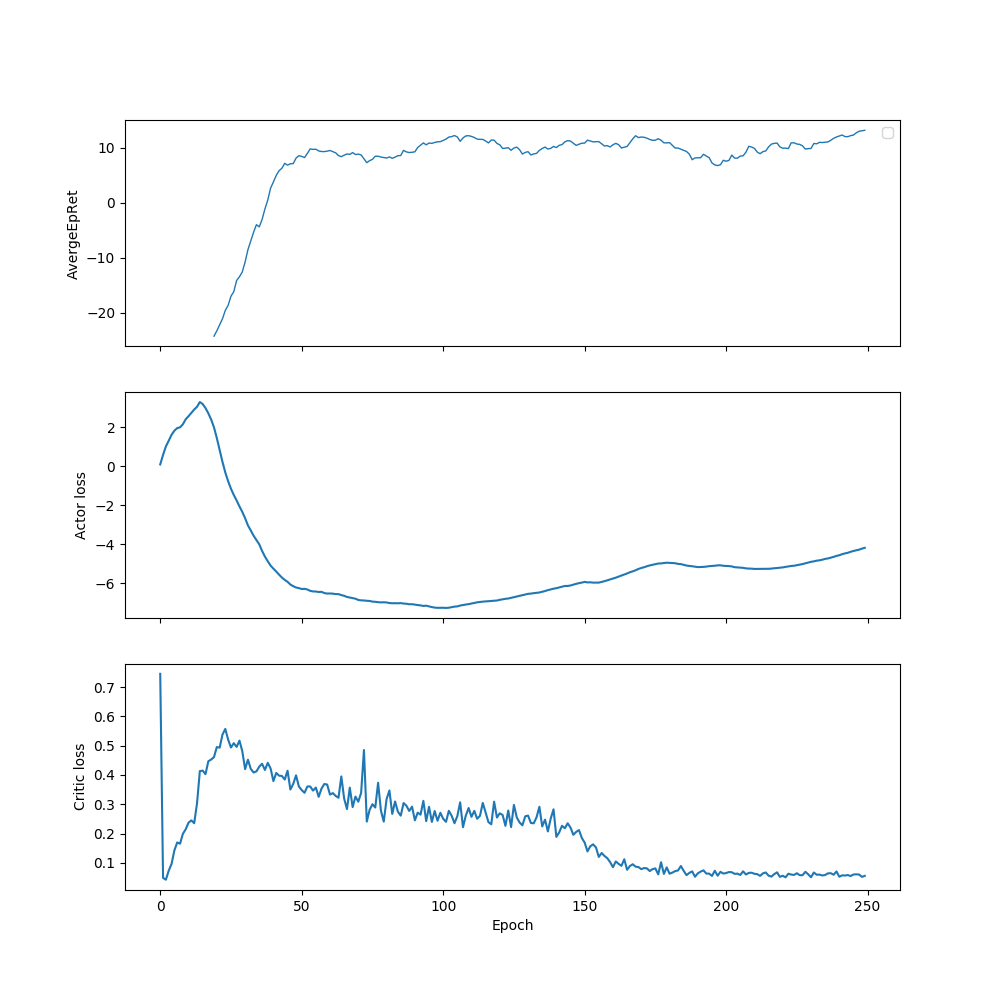

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


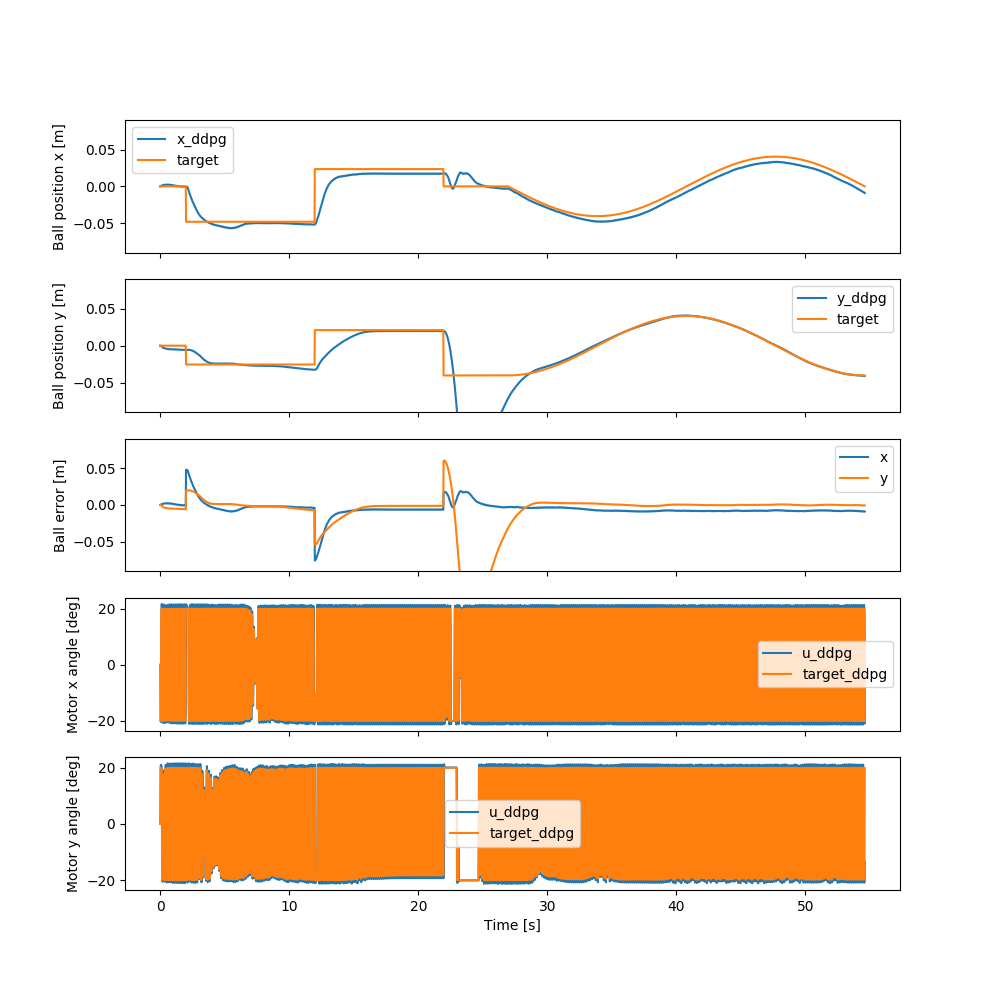

In [31]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()